# Displacement due to a square-shaped load

We want to evaluate the displacement due to an
arbitrary distribution of force density.


$$G_{ij} = \frac{1}{8\pi\mu (1 - \nu)}\left[-(3 - 4\nu)\delta_{ij}\ln(r)
     + \frac{r_i r_j}{r^2}\right]\, .$$


We can compute the displacement given by a force density
$\rho_x(\mathbf{x})\hat{\mathbf{e}}_x + \rho_y(\mathbf{x})\hat{\mathbf{e}}_y$
adding up the individual point contributions, that is, with an integral.

$$u_i(\boldsymbol{\zeta})
= \int\limits_\Omega G_{ij}(\mathbf{x}, \boldsymbol{\zeta}) \rho_j(\mathbf{x})\, \mathrm{d}\Omega(\mathbf{x})$$
  
If we consider that the domain is triangulated we can express the integral as

$$u_i(\boldsymbol{\zeta})
= \sum_{e}\int\limits_{\Omega_e} G_{ij}(\mathbf{x}, \boldsymbol{\zeta})
  \rho_j(\mathbf{x})\, \mathrm{d}\Omega(\mathbf{x})\, .$$
  
Let's consider that the variation of $\rho_i$ and $G_{ij}$ is negligible over
each triagle. Thus, we obtain

\begin{align}
u_i(\boldsymbol{\zeta})
&\approx \sum_{e} G_{ij}(\mathbf{x}_m, \boldsymbol{\zeta}) \rho_i(\mathbf{x}_m) \int\limits_{\Omega_e}\mathrm{d}\Omega(\mathbf{x})\\
&= \sum_{e} G_{ij}(\mathbf{x}_m, \boldsymbol{\zeta}) \rho_j(\mathbf{x}_m) V_e\, ,
\end{align}

where $\mathbf{x}_m$ refers to the centroid of each triangle.

If we consider that the force density is the same over the domain, we get

$$u_i(\boldsymbol{\zeta}) \approx  \left[\sum_{e} G_{ij}(\mathbf{x}_m, \boldsymbol{\zeta}) V_e\right] \rho_j\, .$$

In [1]:
%matplotlib widget

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshio

In [3]:
try:
    repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
    style = repo + "/styles/clean.mplstyle"
    plt.style.use(style)
except:
    pass

In [4]:
mesh = meshio.read("files/square_planet.msh")
pts = mesh.points
tris_planet = mesh.cells[0].data
tris = np.vstack([cells.data for cells in mesh.cells])
x, y, _ = pts.T

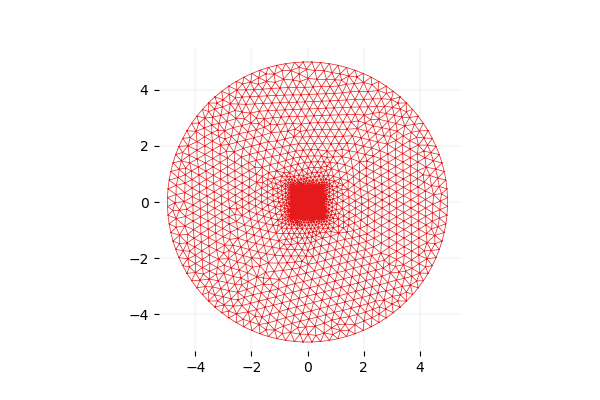

In [5]:
plt.figure()
plt.triplot(x, y, tris, lw=0.5, zorder=4)
plt.axis("image");

In [6]:
def green_disp_2d(r_vec, mu, nu):
    """Green function for Laplace equation
    
    Parameters
    ----------
    r_vec : float
        Vector between the two points

    Returns
    -------
    G : ndarray, float
        Values of the Green_function
    """
    r = np.linalg.norm(r_vec, axis=0)
    G = -(3 - 4*nu)*np.einsum('ij,k', np.eye(2), np.log(r)) + np.einsum('ij,kj->ikj', r_vec, r_vec/r**2)
    return G/(8*mu*(1 - nu))

## Green function visualization

We can visualize the Green function for a point load in the origin
over our mesh.

In [7]:
G_vec = green_disp_2d(pts[:, :2].T, 1, 0.25)

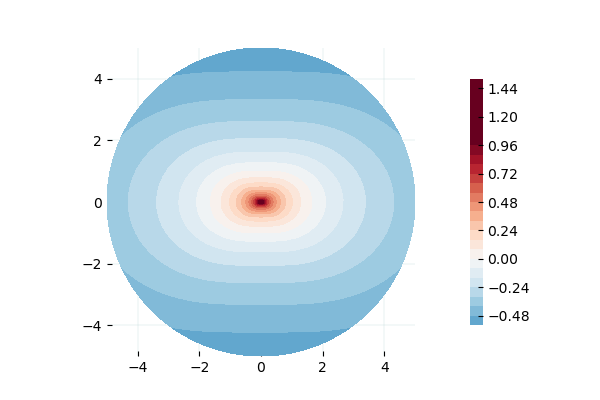

In [8]:
plt.figure()
plt.tricontourf(x, y, tris, G_vec[0, 0, :], 24, cmap="RdBu_r", zorder=4,
                vmin=-1, vmax=1)
plt.colorbar(shrink=0.8)
plt.axis("image");

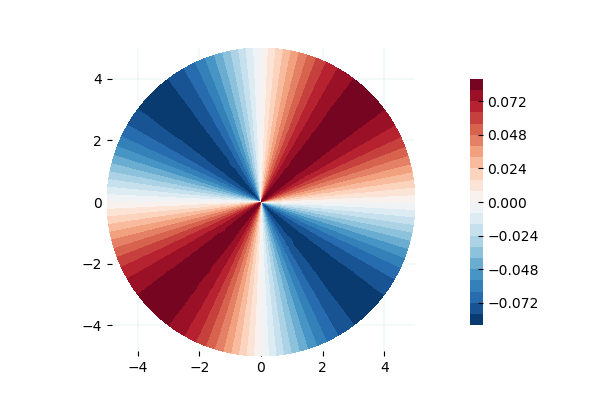

In [9]:
plt.figure()
plt.tricontourf(x, y, tris, G_vec[0, 1, :], 24, cmap="RdBu_r", zorder=4)
plt.colorbar(shrink=0.8)
plt.axis("image");

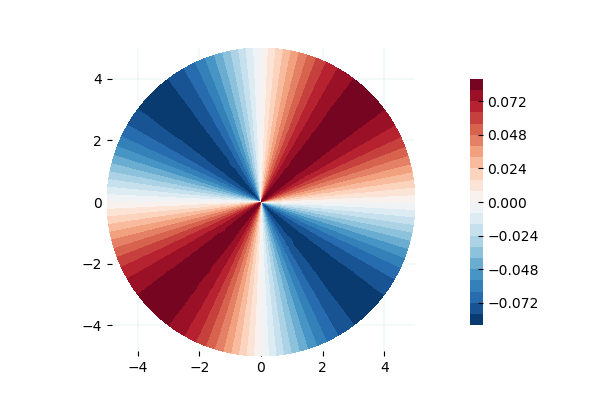

In [10]:
plt.figure()
plt.tricontourf(x, y, tris, G_vec[1, 0, :], 24, cmap="RdBu_r", zorder=4)
plt.colorbar(shrink=0.8)
plt.axis("image");

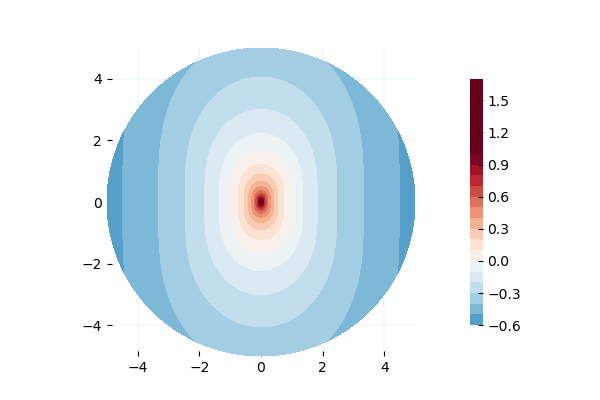

In [11]:
plt.figure()
plt.tricontourf(x, y, tris, G_vec[1, 1, :], 24, cmap="RdBu_r", zorder=4,
                vmin=-1, vmax=1)
plt.colorbar(shrink=0.8)
plt.axis("image");

## Integration over the square

In [12]:
def area_tri(coords):
    """Compute the area of a triangle with given coordinates

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes of the triangle.

    Returns
    -------
    area : float
        Area of the triangle
    """
    mat = coords.copy()
    mat[:, 2] = 1
    return 0.5 * np.abs(np.linalg.det(mat))

In [13]:
disp = np.zeros_like(pts[:, :2])

In [14]:
for tri in tris_planet:
    coords = pts[tri]
    area = area_tri(coords)
    xm, ym, _ = np.mean(coords, axis=0)
    r_vec = pts[:, :2] - np.array([xm, ym])
    G = green_disp_2d(r_vec.T, 1.0, 0.25)
    disp += area * np.einsum("ijk, j", G, np.array([1, 0])).T

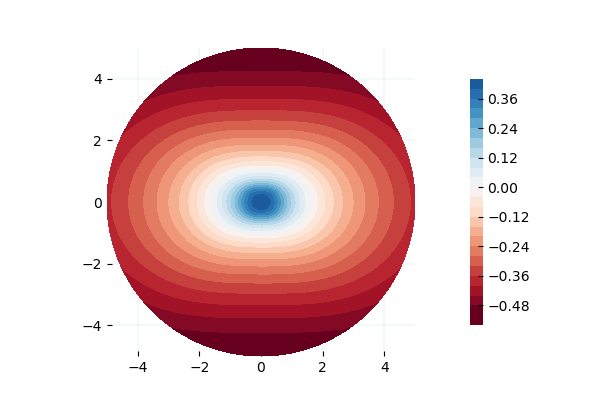

In [15]:
plt.figure()
plt.tricontourf(x, y, tris, disp[:, 0], 24, zorder=4,
                cmap="RdBu", vmin=-0.5, vmax=0.5)
plt.colorbar(shrink=0.8)
plt.axis("image");

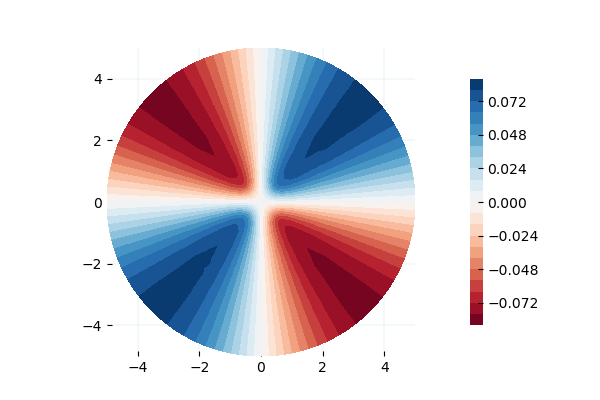

In [16]:
plt.figure()
plt.tricontourf(x, y, tris, disp[:, 1], 24, zorder=4,
                cmap="RdBu")
plt.colorbar(shrink=0.8)
plt.axis("image");

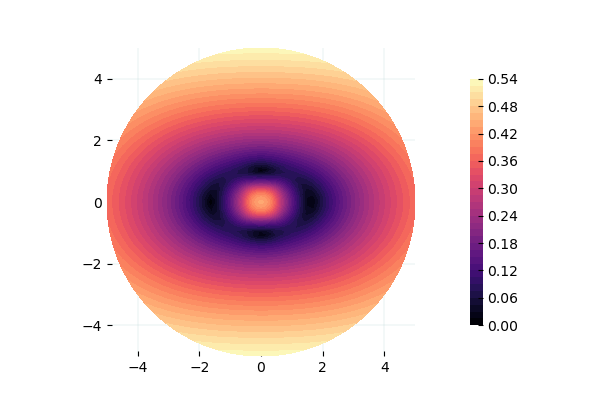

In [17]:
plt.figure()
plt.tricontourf(x, y, tris, np.linalg.norm(disp, axis=1), 50,
                zorder=4, cmap="magma")
plt.colorbar(shrink=0.8)
plt.axis("image");

In [18]:
mesh.point_data["displacement"] = disp

In [19]:
import os

folder = "./files/"
if os.path.isdir(folder):
    pass
else:
    os.mkdir(folder)
    
mesh.write( folder + "square_elast.vtk")

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to gmsh:dim_tags.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to displacement.

Info: VTK format cannot write cell_sets. Converting them to cell_data...

Warning: 2394 cells are not part of any cell set. Using default value -1.